# Klasteryzacja, agregacja i autokorelacja danych

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.environ["OMP_NUM_THREADS"] = '1'
from sklearn.cluster import KMeans

In [2]:
points_1=pd.read_csv('points_1.csv')
points_2=pd.read_csv('points_2.csv')
points_3=pd.read_csv('points_3.csv')

Klasteryzacja metodą k-średnich

<AxesSubplot:title={'center':'elbow curve dla points_1'}, xlabel='N', ylabel='D(N)'>

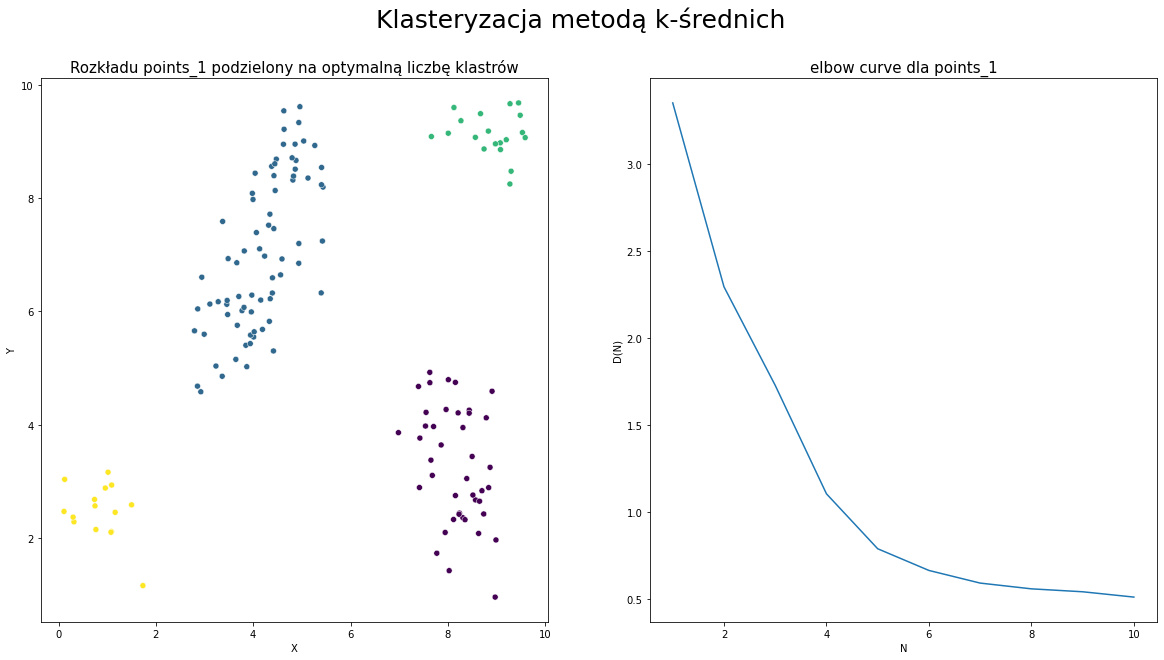

In [3]:
def k_means_elbow_curve_test(points, number_of_clusters):
    """
    Parameters
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    number_of_clusters: list
        Lista określająca zakres testowanej liczby klastrów.
        Przykład: [1, 5]   

    Returns
    -------
    clusters: DataFrame
        Tablica zbierająca wyniki klasteryzacji w następujących kolumnach:
        - "X" - współrzędne X punktów,
        - "Y" - współrzedne Y punktów,
        - kolejne kolumny (ich liczba zależy od liczby testowanych liczebności klastrów) opisane są jako liczba klastrów,
        np. "1", "2", itd. i zawierają numery klastrów, do których zostały przyporządkowane konkretne punkty.
    elbow_curve: DataFrame
        Tablica zbierająca dane niebędne do wykonania wykresu elbow curve w dwóch kolumnach:
        - "N" - liczba klastrów,
        - "D(N)" - średnia odległość punktu od centrum klastra, do którego jest przypisany.
    """
    min_c = number_of_clusters[0]
    max_c = number_of_clusters[1]
    inertias = pd.DataFrame()
    klastry=[]

    for i in range(min_c,max_c + 1):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(points)
        inertias[i] = kmeans.predict(points).tolist()
        d=0
        for j in range(points["X"].size):
            d+=((points["X"][j]-kmeans.cluster_centers_[kmeans.labels_[j]][0])**2+(points["Y"][j]-kmeans.cluster_centers_[kmeans.labels_[j]][1])**2)**0.5
        klastry.append(d/points["X"].size)
    
    inertias.insert(0, 'X', points["X"])
    inertias.insert(1, 'Y', points["Y"])
    return inertias, pd.DataFrame({"N":np.arange(min_c,max_c+1), "D(N)":klastry})

km1, km2=k_means_elbow_curve_test(points_1, [1,10])

fig, ax=plt.subplots(1,2,figsize=(20,10))
fig.suptitle("Klasteryzacja metodą k-średnich", fontsize=25)
kmeans=KMeans(n_clusters=4)
kmeans.fit(points_1)
ax[0].set_title("Rozkładu points_1 podzielony na optymalną liczbę klastrów", fontsize=15)
sns.scatterplot(data=points_1, x="X", y="Y", ax=ax[0], c=kmeans.labels_)

ax[1].set_title("elbow curve dla points_1", fontsize=15)
sns.lineplot(data=km2, x="N", y="D(N)", ax=ax[1])

Agregacja danych na siatce prostokątnej

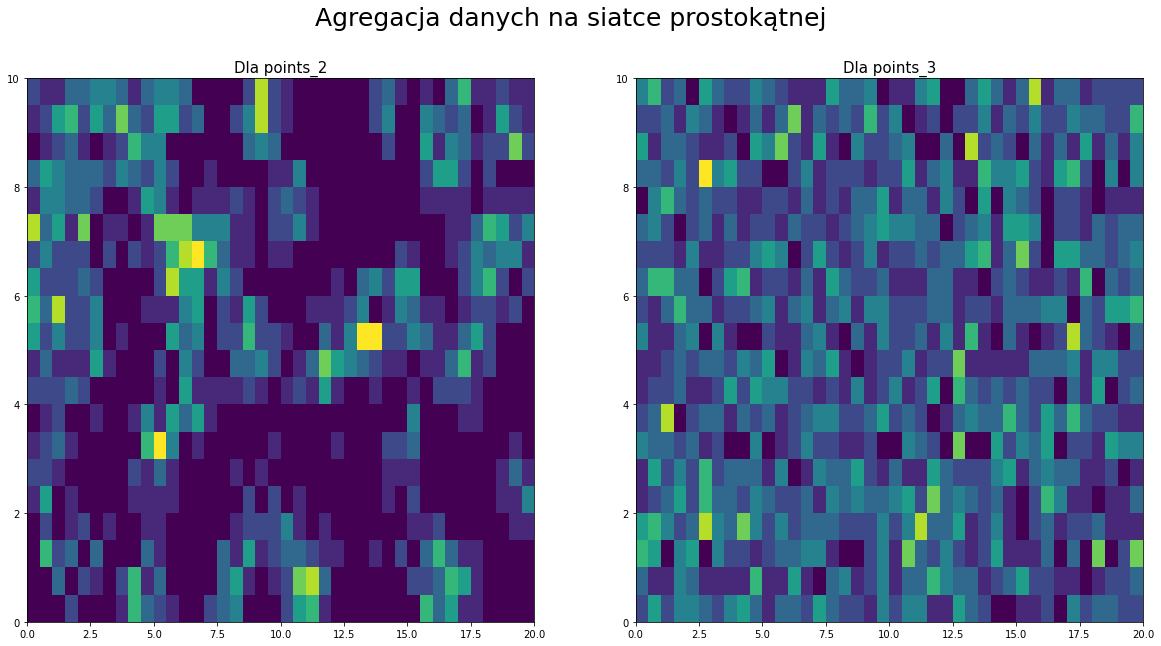

In [4]:
def agregate_on_rectangles(points, bins, x_lim, y_lim):
    """
    Parameters
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    bins: list
        Lista określająca liczbę podobszarów w poziomie i pionie.
        Przykład: [10, 10]
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10]   

    Returns
    -------
    binned_data: list
        Lista zawierająca trzy macierze:
        - 1D ze współrzędnymi krawędzi podobszarów na osi X,
        - 1D ze współrzędnymi krawędzi podobszarów na osi Y,
        - 2D z liczbą punków przypisanych do każdego z podobszarów.
        Na przykład: [array([0, 1, 2]), array([0, 1, 2]), array([[7, 2], [4, 5]])]
    """
    xpoints=np.linspace(x_lim[0], x_lim[1], bins[0]+1)
    ypoints=np.linspace(y_lim[0], y_lim[1], bins[1]+1)
    
    H, xedges, yedges = np.histogram2d(points["X"], points["Y"], bins=(xpoints, ypoints))
    H = H.T
    return [xpoints,ypoints,H]

ap2=agregate_on_rectangles(points_2, [40,20], [0,20], [0,10])
ap3=agregate_on_rectangles(points_3, [40,20], [0,20], [0,10])

fig, ax=plt.subplots(1,2,figsize=(20,10))
fig.suptitle(" Agregacja danych na siatce prostokątnej", fontsize=25)
ax[0].set_title("Dla points_2", fontsize=15)
X,Y=np.meshgrid(ap2[0], ap2[1])
ax[0].grid(False)
ax[0].pcolormesh(X, Y, ap2[2])

ax[1].set_title("Dla points_3", fontsize=15)
X,Y=np.meshgrid(ap3[0], ap3[1])
ax[1].grid(False)
ax[1].pcolormesh(X, Y, ap3[2])

Wykres Morana

<AxesSubplot:title={'center':'wykres Morana dla points_3'}, xlabel='AG_STD', ylabel='SL_STD'>

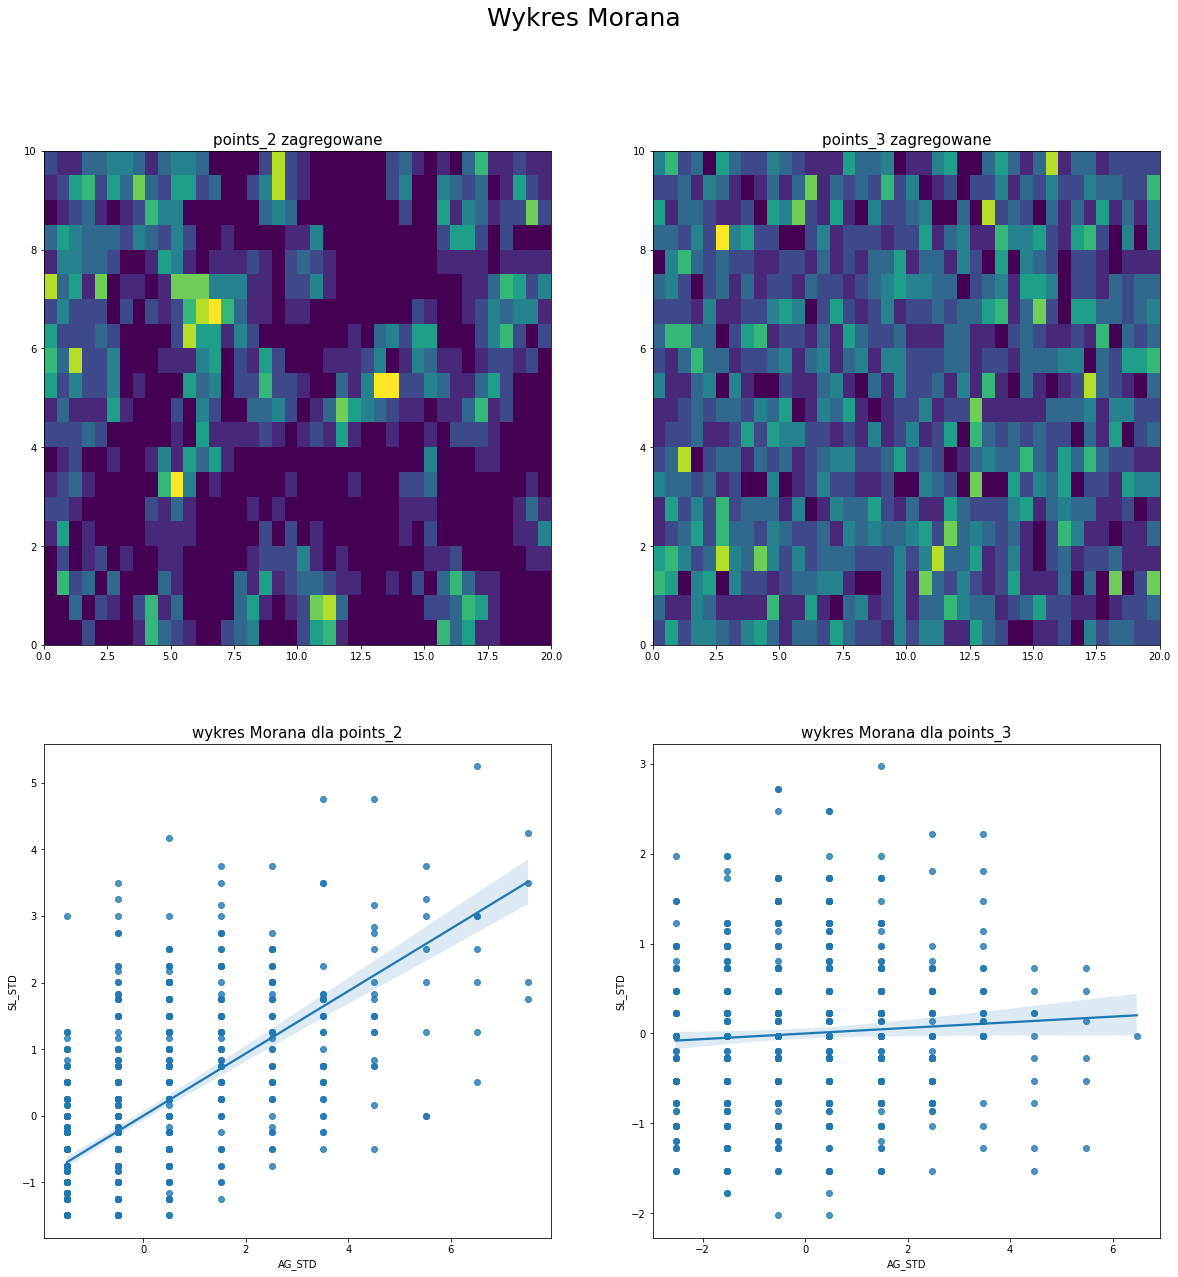

In [5]:
 def getNeighbors(i, j, m, n):
    nL = []
    if i > 0:
        nL.append([i-1,j])
    if i+1 < m:
        nL.append([i+1,j])
    if j > 0:
        nL.append([i,j-1])
    if j+1 < n:
        nL.append([i,j+1])
    return nL

def spatial_weights(bin_counts):
    """
    Parameters
    -------
    bin_counts: array
        Macierz 2D z liczbą punków przypisanych do każdego z podobszarów.

    Returns
    -------
    w: array
        Macierz 2D zawierająca wagi przestrzenne.
    """    
    neighbors=[]
    maxX=len(bin_counts[0])
    maxY=len(bin_counts)
    spatialWeight=np.zeros((maxX*maxY, maxX*maxY))
    
    for j in range(maxY):
        for i in range(maxX):
            neighbors.append(getNeighbors(i,j,maxX, maxY))
    
    for i in range(maxX*maxY):
        l=neighbors[i]
        for n in l:
            spatialWeight[i, n[1]*maxX+n[0]]=1
    return spatialWeight  


def spatial_lag(binned_data):
    """
    Parameters
    -------
    binned_data: list
        Lista zawierająca trzy macierze:
        - 1D ze współrzędnymi krawędzi podobszarów na osi X,
        - 1D ze współrzędnymi krawędzi podobszarów na osi Y,
        - 2D z liczbą punków przypisanych do każdego z podobszarów.
        Na przykład: [array([0, 1, 2]), array([0, 1, 2]), array([[7, 2], [4, 5]])]

    Returns
    -------
    lagged_data: list
        Lista zawierająca trzy macierze:
        - 1D ze współrzędnymi krawędzi podobszarów na osi X,
        - 1D ze współrzędnymi krawędzi podobszarów na osi Y,
        - 2D z wyliczonymi wartościami opóźnienia przestrzennego.
        Na przykład: [array([0, 1, 2]), array([0, 1, 2]), array([[7, 2], [4, 5]])]
    """    
    w=spatial_weights(binned_data[2])
    X=binned_data[2].flatten()
    LC=[]
    for j in w:
        lc=np.sum(j*X)/np.sum(j)
        LC.append(lc)
    return [binned_data[0], binned_data[1],np.reshape(LC,binned_data[2].shape)]

def moran_plot_data(bin_counts, lagged_counts):
    """
    Parameters
    -------
    bin_counts: array
        Macierz 2D z liczbą punków przypisanych do każdego z podobszarów.
    lagged_counts: array
        Macierz 2D z wartościami opóźnienia przestrzennego przypisanego do każdego z podobszarów.

    Returns
    -------
    moran_plot_data: DataFrame
        Tablica zawierająca dwie kolumny danych niebędnych do wykonania wykresu Morana:
        - "AG_STD" - ustandarywowane dane zagregowane,
        - "SL_STD" - ustandarywzowane wartości opóźnienia przestrzennego.
    """ 
    ag=bin_counts-np.mean(bin_counts)
    sl=lagged_counts-np.mean(lagged_counts)
    return pd.DataFrame({"AG_STD":ag.flatten(), "SL_STD":sl.flatten()})

sp2=spatial_weights(ap2[2])
sp3=spatial_weights(ap3[2])

slp2=spatial_lag(ap2)
slp3=spatial_lag(ap3)

mp2=moran_plot_data(ap2[2],slp2[2])
mp3=moran_plot_data(ap3[2],slp3[2])

fig, ax=plt.subplots(2,2,figsize=(20,20))
fig.suptitle("Wykres Morana", fontsize=25)
ax[0,0].set_title("points_2 zagregowane",fontsize=15)
X,Y=np.meshgrid(ap2[0], ap2[1])
ax[0,0].grid(False)
ax[0,0].pcolormesh(X, Y, ap2[2])

ax[0,1].set_title("points_3 zagregowane", fontsize=15)
X,Y=np.meshgrid(ap3[0], ap3[1])
ax[0,1].grid(False)
ax[0,1].pcolormesh(X, Y, ap3[2])

ax[1,0].set_title("wykres Morana dla points_2", fontsize=15)
sns.regplot(x=mp2["AG_STD"], y=mp2["SL_STD"], ax=ax[1,0])

ax[1,1].set_title("wykres Morana dla points_3", fontsize=15)
sns.regplot(x=mp3["AG_STD"], y=mp3["SL_STD"], ax=ax[1,1])